#Imports & Environment

In [ ]:
# Imports
import pandas as pd
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
import os

# Load environment 
load_dotenv()
DB_HOST = os.getenv("DB_HOST", "localhost")
DB_PORT = os.getenv("DB_PORT", "5432")
DB_NAME = os.getenv("DB_NAME", "mobilebank")
DB_USER = os.getenv("DB_USER", "postgres")
DB_PASSWORD = os.getenv("DB_PASSWORD", "8075")


#Connect to PostgreSQL

In [2]:
# Connect to PostgreSQL
engine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

print("✔ Connected to PostgreSQL")


✔ Connected to PostgreSQL


#Load CSV

In [3]:
# Load final-review.csv
df = pd.read_csv(r"C:\Users\user\Desktop\Project\Mobile-Banking\data\processed\reviews_with_sentiment.csv")
print(f"Loaded {len(df)} reviews")
df.head()


Loaded 960 reviews


,review_id,review_text,rating,review_date,bank_code,bank_name,user_name,thumbs_up,reply_content,source,clean_review,compound,sentiment,clean_text
0,1,Very disappointing application. it's getting w...,1,2025-10-31 19:25:05,DASHEN,Dashen Bank,A.Senay ZENEBE,0,NaN,PlayStore,very disappointing application. it's getting w...,-0.7956,Negative,very disappointing application. it's getting w...
1,2,"Banking made simple, smart, and safe.",5,2025-10-28 15:35:23,DASHEN,Dashen Bank,Bilen Atinafe,0,NaN,PlayStore,"banking made simple, smart, and safe.",0.6808,Positive,"banking made simple, smart, and safe."
2,3,It is the best of all i liked it i used it alm...,5,2025-10-27 19:37:55,DASHEN,Dashen Bank,Guta Gundo,0,NaN,PlayStore,it is the best of all i liked it i used it alm...,0.8519,Positive,it is the best of all i liked it i used it alm...
3,4,gngu,5,2025-10-21 00:31:58,DASHEN,Dashen Bank,Yalelet Ahmed,0,NaN,PlayStore,gngu,0.0000,Neutral,gngu
4,5,"The app is very good , but it does not tell th...",4,2025-09-09 22:24:44,DASHEN,Dashen Bank,Esrael Worku,0,NaN,PlayStore,"the app is very good , but it does not tell th...",0.7504,Positive,"the app is very good , but it does not tell th..."


#Create Tables

In [ ]:
try:
    engine = create_engine(
        f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
    )
    connection = engine.connect()
    print("✔ Connected to PostgreSQL")
except OperationalError as e:
    print("❌ Connection failed. Check your PostgreSQL credentials and server status.")
    print(e)
    exit()

#: Insert Banks

In [ ]:
# Insert banks
banks = df["bank"].unique()

with engine.begin() as conn:  # Auto commit
    for bank in banks:
        conn.execute(text("""
        INSERT INTO banks (bank_name, app_name)
        VALUES (:bank_name, :app_name)
        ON CONFLICT (bank_name) DO NOTHING;
        """), {"bank_name": bank, "app_name": f"{bank} Mobile Banking App"})

    # Fetch bank_id mapping
    result = conn.execute(text("SELECT bank_id, bank_name FROM banks;"))
    bank_map = {row["bank_name"]: row["bank_id"] for row in result}

print(f"✔ Inserted {len(bank_map)} banks")


#Insert Reviews

In [ ]:
# Insert reviews
with engine.begin() as conn:
    for _, row in df.iterrows():
        conn.execute(text("""
        INSERT INTO reviews 
        (bank_id, review_text, rating, review_date, sentiment_label, sentiment_score, source)
        VALUES (:bank_id, :review_text, :rating, :review_date, :sentiment_label, :sentiment_score, :source)
        """), {
            "bank_id": bank_map[row["bank"]],
            "review_text": row["review_text"],
            "rating": row.get("rating", None),
            "review_date": row.get("review_date", None),
            "sentiment_label": row.get("sentiment_label", None),
            "sentiment_score": row.get("sentiment_score", None),
            "source": "Google Play"
        })

print("✔ Inserted all reviews")


#save

In [70]:
import pandas as pd
from sqlalchemy import create_engine

# -------------------------------
# PostgreSQL connection info
# -------------------------------
DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "mobilebank"
DB_USER = "postgres"
DB_PASSWORD = "8075"  # replace with your password

engine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

# -------------------------------
# Query combined data from banks + reviews
# -------------------------------
query = """
SELECT 
    r.review_id,
    b.bank_name,
    b.app_name,
    r.review_text,
    r.rating,
    r.review_date,
    r.sentiment_label,
    r.sentiment_score,
    r.source
FROM reviews r
JOIN banks b ON r.bank_id = b.bank_id
ORDER BY r.review_id;
"""

# Load data into DataFrame
df_export = pd.read_sql(query, engine)
print(f"✔ Loaded {len(df_export)} rows from PostgreSQL")

# -------------------------------
# Save to CSV
# -------------------------------
save_path = r"C:\Users\user\Desktop\Project\Mobile-Banking\data\processed\review_final.csv"
df_export.to_csv(save_path, index=False, encoding='utf-8')

print(f"✔ Exported database data to CSV: {save_path}")


✔ Loaded 960 rows from PostgreSQL
✔ Exported database data to CSV: C:\Users\user\Desktop\Project\Mobile-Banking\data\processed\review_final.csv


#load

In [90]:
import pandas as pd

# Load final reviews CSV
df = pd.read_csv(r"C:\Users\user\Desktop\Project\Mobile-Banking\data\processed\review_final.csv")

print(df.head())
print(df.info())


   review_id    bank_name                        app_name  \
0          1  Dashen Bank  Dashen Bank Mobile Banking App   
1          2  Dashen Bank  Dashen Bank Mobile Banking App   
2          3  Dashen Bank  Dashen Bank Mobile Banking App   
3          4  Dashen Bank  Dashen Bank Mobile Banking App   
4          5  Dashen Bank  Dashen Bank Mobile Banking App   

                                         review_text  rating review_date  \
0  Very disappointing application. it's getting w...     1.0  2025-10-31   
1              Banking made simple, smart, and safe.     5.0  2025-10-28   
2  It is the best of all i liked it i used it alm...     5.0  2025-10-27   
3                                               gngu     5.0  2025-10-21   
4  The app is very good , but it does not tell th...     4.0  2025-09-09   

   sentiment_label  sentiment_score       source  
0              NaN              NaN  Google Play  
1              NaN              NaN  Google Play  
2              NaN     

## Ensure dates are parsed


In [89]:
df["review_date"] = pd.to_datetime(df["review_date"], errors="coerce")

print("Data loaded successfully!")
print(df.head())

Data loaded successfully!
   review_id    bank_name                        app_name  \
0          1  Dashen Bank  Dashen Bank Mobile Banking App   
1          2  Dashen Bank  Dashen Bank Mobile Banking App   
2          3  Dashen Bank  Dashen Bank Mobile Banking App   
3          4  Dashen Bank  Dashen Bank Mobile Banking App   
4          5  Dashen Bank  Dashen Bank Mobile Banking App   

                                         review_text  rating review_date  \
0  Very disappointing application. it's getting w...     1.0  2025-10-31   
1              Banking made simple, smart, and safe.     5.0  2025-10-28   
2  It is the best of all i liked it i used it alm...     5.0  2025-10-27   
3                                               gngu     5.0  2025-10-21   
4  The app is very good , but it does not tell th...     4.0  2025-09-09   

  sentiment_label  sentiment_score       source  
0             nan              NaN  Google Play  
1             nan              NaN  Google Play  


#Drivers & Pain Points

In [91]:

drivers = {}
pain_points = {}

for bank in df['bank_name'].unique():
    bank_reviews = df[df['bank_name'] == bank]
    
    # Positive reviews
    pos_reviews = bank_reviews[bank_reviews['sentiment_label'] == 'Positive']['review_text']
    drivers[bank] = pos_reviews.value_counts().head(5).index.tolist()  # top keywords/phrases
    
    # Negative reviews
    neg_reviews = bank_reviews[bank_reviews['sentiment_label'] == 'Negative']['review_text']
    pain_points[bank] = neg_reviews.value_counts().head(5).index.tolist()

print("Drivers:", drivers)
print("Pain Points:", pain_points)


Drivers: {'Dashen Bank': [], 'Commercial Bank of Ethiopia': [], 'Abyssinia Bank': []}
Pain Points: {'Dashen Bank': [], 'Commercial Bank of Ethiopia': [], 'Abyssinia Bank': []}


#Compare Banks


In [84]:
avg_rating = df.groupby('bank_name')['rating'].mean()
sentiment_counts = df.groupby(['bank_name', 'sentiment_label']).size().unstack(fill_value=0)

print("Average Rating per Bank:\n", avg_rating)
print("Sentiment Counts per Bank:\n", sentiment_counts)


Average Rating per Bank:
 bank_name
Abyssinia Bank                 3.091743
Commercial Bank of Ethiopia    3.925566
Dashen Bank                    3.888889
Name: rating, dtype: float64
Sentiment Counts per Bank:
 Empty DataFrame
Columns: []
Index: []


#RATING DISTRIBUTION


<function matplotlib.pyplot.show(close=None, block=None)>

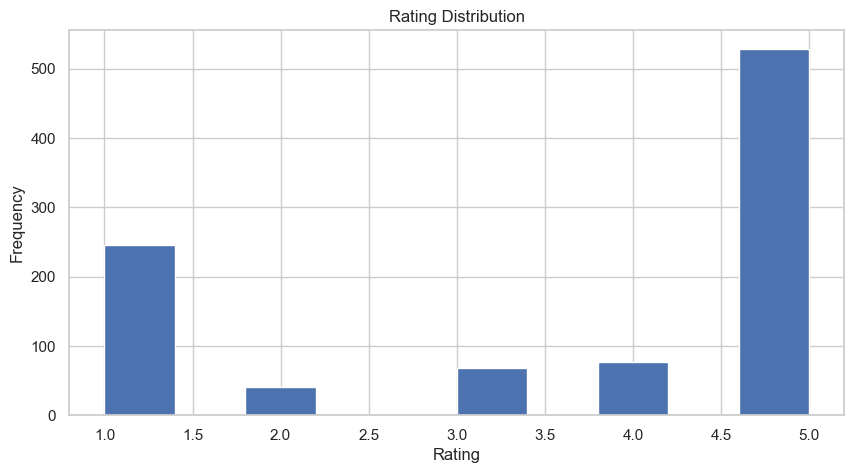

In [93]:
plt.figure(figsize=(10, 5))
plt.hist(df["rating"].dropna())
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show

# Rating distribution

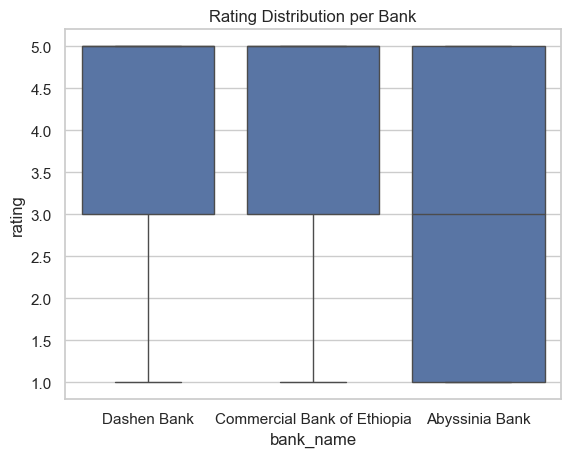

In [75]:
sns.boxplot(data=df, x='bank_name', y='rating')
plt.title("Rating Distribution per Bank")
plt.show()


# SENTIMENT DISTRIBUTION PER BANK

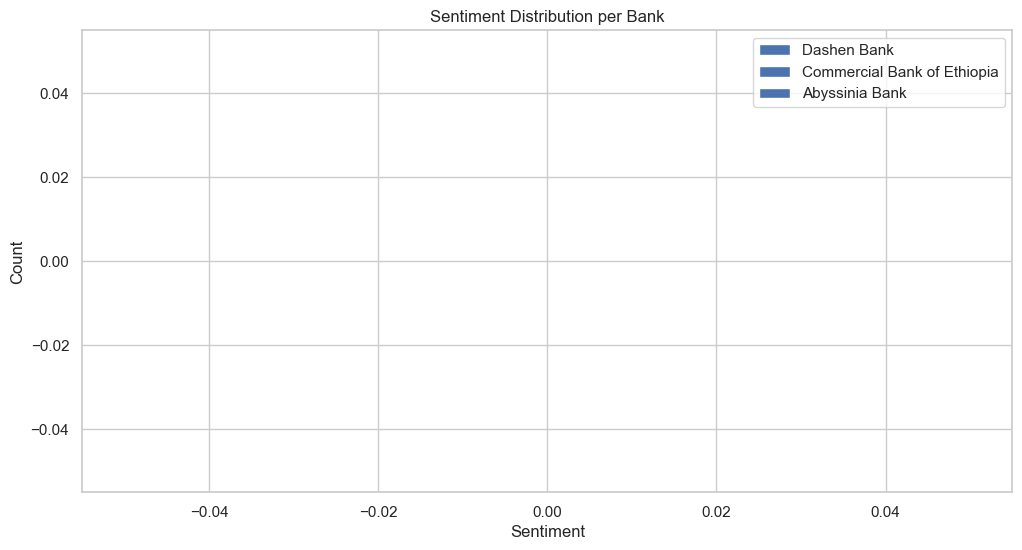

In [94]:
sentiment_counts = df.groupby(["bank_name", "sentiment_label"]).size().reset_index(name="count")

plt.figure(figsize=(12, 6))

for bank in df["bank_name"].unique():
    bank_data = sentiment_counts[sentiment_counts["bank_name"] == bank]
    plt.bar(bank_data["sentiment_label"], bank_data["count"])

plt.title("Sentiment Distribution per Bank")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.legend(df["bank_name"].unique())
plt.show()

#rating is numeric

In [97]:
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")

#

In [98]:
avg_rating = df.groupby("bank_name")["rating"].mean().reset_index()
print("Average Rating Per Bank:")
print(avg_rating)

Average Rating Per Bank:
                     bank_name    rating
0               Abyssinia Bank  3.091743
1  Commercial Bank of Ethiopia  3.925566
2                  Dashen Bank  3.888889
